Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

- **Actinic Keratosis**: This is a rough, scaly patch caused by sun damage. It can potentially progress to squamous cell carcinoma if left untreated, so it might be life-threatening.  
- **Basal Cell Carcinoma**: This is a common, slow-growing skin cancer. It rarely spreads and is not usually life-threatening if treated early.  
- **Dermatofibroma**: This is a benign, firm, reddish-brown nodule. It is not life-threatening.  
- **Melanoma**: This is a highly aggressive skin cancer that originates from melanocytes. It can be life-threatening if not detected early.  
- **Nevus**: This is a mole or birthmark, and it is typically benign. It is not life-threatening, although some moles can become cancerous.  
- **Pigmented Benign Keratosis**: These are non-cancerous pigmented growths that often resemble warts. They are not life-threatening.  
- **Seborrheic Keratosis**: These are harmless, wart-like growths with a "stuck-on" appearance. They are not life-threatening.  
- **Squamous Cell Carcinoma**: This is a faster-growing skin cancer that can metastasize. It can be life-threatening if left untreated.  
- **Vascular Lesion**: These are benign abnormalities of blood vessels, like hemangiomas. They are not life-threatening.

Distinguishing between different types of skin lesions visually is often extremely challenging, as many lesions share similar physical characteristics like color, texture, and shape. For instance, melanoma can resemble a benign nevus, and actinic keratosis might mimic seborrheic keratosis. These visual overlaps mean that clinical diagnosis often requires additional tests, such as dermoscopy, biopsies, or histopathological analysis, to accurately classify the lesion type.

In machine learning models, these challenges are reflected as well:  

1. **Visual Similarity**: The shared features among different classes make it harder for the model to differentiate between them, increasing the risk of misclassification.  
2. **Class Imbalance**: Rare conditions, such as melanoma, often have fewer examples in datasets, which can lead to biased predictions.  
3. **Noisy Data**: Images might have variations in lighting, resolution, and angles, or artifacts like hairs and shadows, which can confuse the model.  
4. **Generalization**: Skin tones, lesion presentations, and image quality can vary significantly, making it hard for the model to perform well on unseen data.  
5. **Feature Extraction**: Subtle patterns that distinguish classes may not be immediately apparent to the model without highly specialized preprocessing or augmentation.

`Addressing these challenges requires high-quality annotated datasets, careful preprocessing, and robust validation methods to ensure reliable performance and generalizability of the machine learning model`

`Most of these tasks are beyond the scope of this student exercise, and I will only attempt to emulate real-life scenarios.`

### Importing all the important libraries

In [40]:
# General utils
import os
import shutil
from collections import Counter
import glob

# Image sampling
import Augmentor

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Some additional metrics 
from sklearn.metrics import classification_report, confusion_matrix

# Model building
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model


In [ ]:
#---------------------
# Some handy functions
#---------------------

def plot_training_history(history, model_name="Model"):
    """
    Plots the training and validation accuracy and loss over epochs with markers for each epoch
    and x-axis ticks set to increments of 5.

    Parameters:
    history (History): Keras History object returned by model.fit() containing
                       the training and validation accuracy and loss.
    model_name (str): The name of the model to display as the overall title.

    Returns:
    None: Displays the plot.
    """
    # Create a 1x2 grid for the two plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Set a consistent y-axis scale
    accuracy_min, accuracy_max = 0, 1   # Accuracy range between 0 and 1
    loss_min, loss_max = 0, 5           # Fixed range for loss between 0 and 5

    # Accuracy plot with consistent y-axis scale, fixed x-axis ticks, and markers
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    axes[0].set_ylim(accuracy_min, accuracy_max)    # Set y-axis range for accuracy
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend(loc='lower right')
    axes[0].set_title('Training and Validation Accuracy')

    # Loss plot with consistent y-axis scale, fixed x-axis ticks, and markers
    axes[1].plot(history.history['loss'], label='Training Loss', marker='o')
    axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='o')
    axes[1].set_ylim(loss_min, loss_max)  # Fixed y-axis range for loss
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend(loc='upper right')
    axes[1].set_title('Training and Validation Loss')

    # Set overall title for the model
    fig.suptitle(f'{model_name}', fontsize=16)

def plot_confusion_matrix(model, val_ds, class_names):
    """
    Generates and plots the confusion matrix for a given model and validation dataset.

    Parameters:
    model (tf.keras.Model): Trained model to use for predictions.
    val_ds (tf.data.Dataset): Validation dataset containing images and labels.
    class_names (list): List of class names corresponding to the model's output classes.

    Returns:
    None: Displays the confusion matrix plot.
    """
    # Get true labels and predictions
    y_true = []
    y_pred = []

    for images, labels in val_ds:
        predictions = model.predict(images, verbose=False)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))

    # Confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix on Validation Set")
    plt.show()

    # Generate the classification report
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=False)
    report_df = pd.DataFrame(report).transpose()

    # Display the classification report as a table
    print("Classification Report on Validation Set")
    display(report_df)

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
train_dir = "data/Train"
test_dir = "data/Test"

In [57]:
# Get rid of images created by augmentor in previous run.
# This is required for re-runs

# Iterate through each class directory
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    
    # Check if the 'output' folder exists within the class directory
    output_path = os.path.join(class_path, "output")
    if os.path.exists(output_path) and os.path.isdir(output_path):
        # Delete the 'output' folder and all its contents
        shutil.rmtree(output_path)
        print(f"Deleted 'output' folder in {class_name} directory.")
    else:
        print(f"No 'output' folder found in {class_name} directory.")

Deleted 'output' folder in actinic keratosis directory.
Deleted 'output' folder in basal cell carcinoma directory.
Deleted 'output' folder in dermatofibroma directory.
Deleted 'output' folder in melanoma directory.
Deleted 'output' folder in nevus directory.
Deleted 'output' folder in pigmented benign keratosis directory.
Deleted 'output' folder in seborrheic keratosis directory.
Deleted 'output' folder in squamous cell carcinoma directory.
Deleted 'output' folder in vascular lesion directory.


In [5]:
# Counting images in each class
train_counts = Counter([os.path.basename(os.path.dirname(p)) for p in glob.glob(f"{train_dir}/*/*")])
test_counts = Counter([os.path.basename(os.path.dirname(p)) for p in glob.glob(f"{test_dir}/*/*")])

print("Training set class distribution:", train_counts)
print("Test set class distribution:", test_counts)

Training set class distribution: Counter({'pigmented benign keratosis': 462, 'melanoma': 438, 'basal cell carcinoma': 376, 'nevus': 357, 'squamous cell carcinoma': 181, 'vascular lesion': 139, 'actinic keratosis': 114, 'dermatofibroma': 95, 'seborrheic keratosis': 77})
Test set class distribution: Counter({'actinic keratosis': 16, 'basal cell carcinoma': 16, 'dermatofibroma': 16, 'melanoma': 16, 'nevus': 16, 'pigmented benign keratosis': 16, 'squamous cell carcinoma': 16, 'seborrheic keratosis': 3, 'vascular lesion': 3})


### Load images using keras.preprocessing

#### Data Preparation for Training and Validation

Following code prepares datasets for training, validation, and testing from image directories. It splits the training directory into training and validation subsets, resizes images to a consistent size (`180x180`), and batches them for efficient processing. The `cache` and `prefetch` methods are applied to optimize dataset loading and improve performance during training.

In [6]:
batch_size = 64
img_height = 180
img_width = 180

AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.
Found 118 files belonging to 9 classes.


In [7]:
for i, n in enumerate(class_names):
    print (i, ':', n)

0 : actinic keratosis
1 : basal cell carcinoma
2 : dermatofibroma
3 : melanoma
4 : nevus
5 : pigmented benign keratosis
6 : seborrheic keratosis
7 : squamous cell carcinoma
8 : vascular lesion


In [8]:
num_classes = len(class_names)

#### Visualizing an image from each class


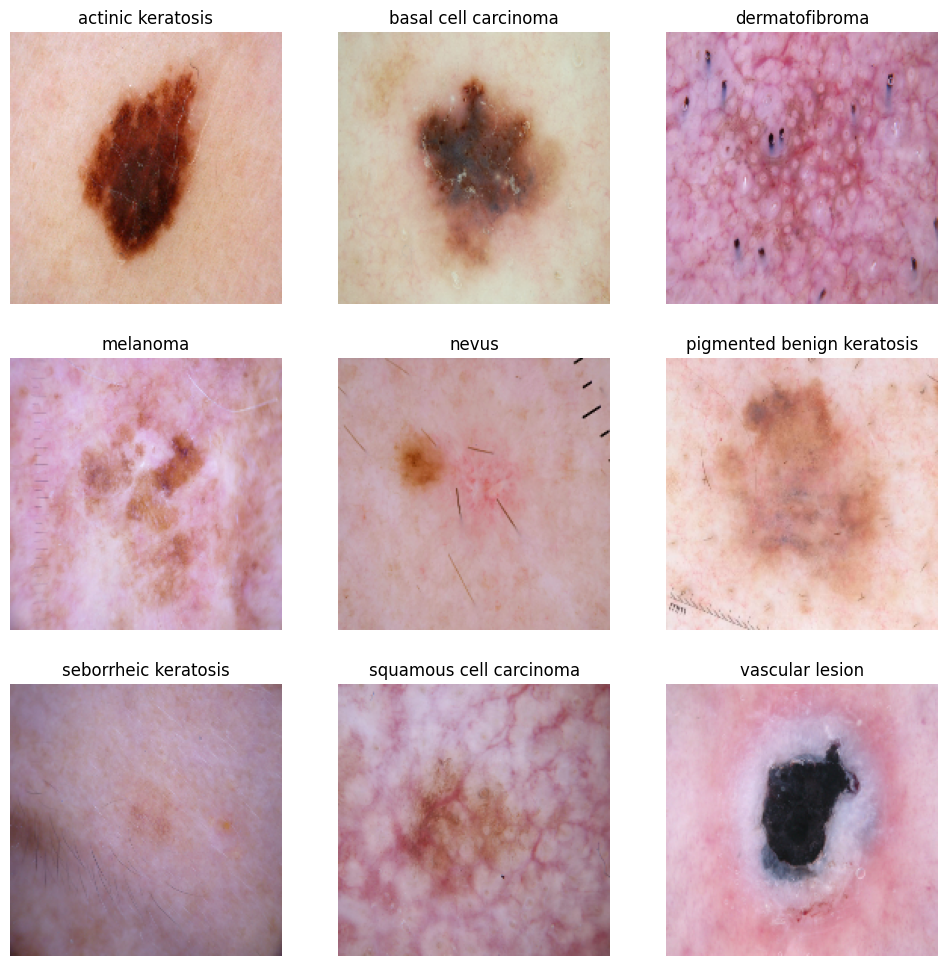

In [9]:
# Display a sample image from each class
plt.figure(figsize=(12, 12))

for i in range(num_classes):
    # Filter the dataset for images of the current class
    class_ds = train_ds.filter(lambda x, y: tf.reduce_any(y == i))

    # Take one batch and one image from that batch
    for images, labels in class_ds.take(1):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.title(class_names[i])
        plt.axis("off")

plt.show()

### First Base Model 

I am starting with a base CNN model that achieves over 80% accuracy on the training data and will subsequently apply various techniques to enhance its performance further.

This code defines a Convolutional Neural Network (CNN) model for multi-class classification. It normalizes input images, applies three convolutional blocks (each with `Conv2D` and `MaxPooling2D` layers), and concludes with fully connected dense layers. The final `Dense` layer uses a softmax activation to predict class probabilities.

In [ ]:
# Create the CNN model
modelA = models.Sequential([
        # Input layer specifying the shape of the input images
        layers.Input(shape=(img_height, img_width, 3)),
        
        # Normalize pixel values to the range [0, 1]
        layers.Rescaling(1./255),
        
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu'),  # Apply 32 filters with a 3x3 kernel and ReLU activation
        layers.MaxPooling2D(),                         # Downsample the feature map using max pooling
        # layers.Dropout(0.2),                         # Dropout for regularization (commented out)

        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu'),  # Apply 64 filters with a 3x3 kernel and ReLU activation
        layers.MaxPooling2D(),                         # Downsample the feature map using max pooling
        # layers.Dropout(0.2),                         # Dropout for regularization (commented out)

        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu'), # Apply 128 filters with a 3x3 kernel and ReLU activation
        layers.MaxPooling2D(),                         # Downsample the feature map using max pooling
        # layers.Dropout(0.2),                         # Dropout for regularization (commented out)

        # Flatten and add dense layers
        layers.Flatten(),                              # Flatten the feature map into a 1D vector
        layers.Dense(128, activation='relu'),          # Fully connected layer with 128 neurons and ReLU activation
        # layers.Dropout(0.4),                         # Dropout for regularization (commented out)

        # Output layer with softmax activation for multi-class classification
        layers.Dense(num_classes, activation='softmax')
    ],
    name='ModelA'  # Name the model as "ModelA"
)

#### Compile the model

In [ ]:
# Compile the model
modelA.compile(
    optimizer='adam',                           # Using the Adam optimizer for efficient and adaptive learning
    loss='sparse_categorical_crossentropy',     # Using sparse categorical cross-entropy as the loss function 
                                                # since the labels are integer-encoded and not one-hot encoded
    metrics=['accuracy']                        # Monitoring accuracy as a performance metric
)

# Display the summary of the model architecture
modelA.summary()                                # Provides a detailed overview of the model's layers, parameters, 
                                                # and output shapes to verify its structure and size

Model: "ModelA"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

#### Train the model

In [12]:
epochs = 20
historyA = modelA.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 379ms/step - accuracy: 0.1690 - loss: 2.6516 - val_accuracy: 0.2707 - val_loss: 1.9951
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 352ms/step - accuracy: 0.2944 - loss: 1.9271 - val_accuracy: 0.3669 - val_loss: 1.7979
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 365ms/step - accuracy: 0.4079 - loss: 1.6919 - val_accuracy: 0.4877 - val_loss: 1.5621
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 369ms/step - accuracy: 0.4785 - loss: 1.5185 - val_accuracy: 0.4877 - val_loss: 1.4671
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 386ms/step - accuracy: 0.5185 - loss: 1.3899 - val_accuracy: 0.4832 - val_loss: 1.4458
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 399ms/step - accuracy: 0.5279 - loss: 1.3630 - val_accuracy: 0.5123 - val_loss: 1.4342
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 406ms/step - accuracy: 0.5765 - loss: 1.2127 - val_accuracy: 0.5391 - val_loss: 1.4248
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 391ms/step - accuracy: 0.6054 - loss: 1.1362 - val_accu

#### Visualizing training results

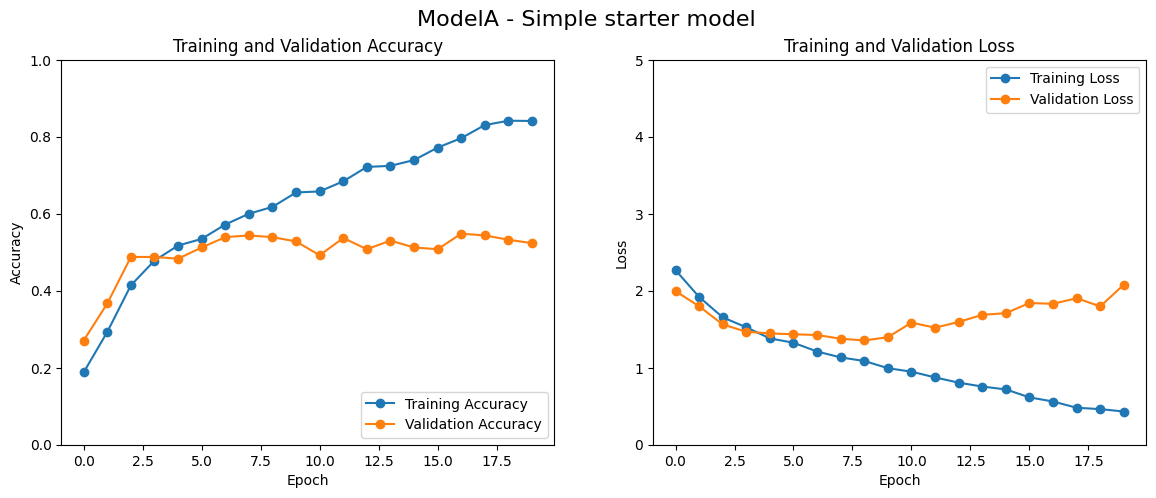

In [14]:
plot_training_history(history=historyA, model_name='ModelA - Simple starter model')

#### Model Summary

The base CNN model, **ModelA**, demonstrates solid performance on the training data, achieving an accuracy of **85.5%** by the end of 20 epochs. However, the validation accuracy plateaus at around **53.2%**, indicating that the model is overfitting to the training data.

Key observations:
1. **Training Performance**:
   - The model learns progressively well on the training data, with a smooth increase in accuracy and a consistent decrease in loss.
   - By epoch 20, the training loss reaches **0.4122**, indicating effective optimization for the training set.

2. **Validation Performance**:
   - Validation accuracy peaks around **54%** (epoch 17) but fluctuates slightly afterward, failing to match the training performance.
   - The validation loss stops decreasing after a few epochs and begins to increase, suggesting **overfitting**.

3. **Visualization Insights**:
   - The accuracy and loss curves reveal a significant gap between training and validation metrics, further highlighting overfitting.

The model provides a good starting point, but its limited generalization to the validation data reflects the need for adjustments to improve performance on unseen data.

### Model with Data Augmentation

ModelB will improve on ModelA by incorporating a **data augmentation pipeline** using Keras to enhance the model's ability to generalize. Data augmentation introduces variability in the training data by applying random transformations, such as rotations, flips, zooms, and brightness adjustments. This helps the model become more robust to real-world variations and reduces overfitting by artificially increasing the diversity of the training set. Unlike ModelA, which overfits due to limited data variability, ModelB will leverage these augmented images to improve validation accuracy and generalization to unseen data.

In [16]:
# Create layer with various augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),            # Randomly flip images horizontally
    layers.RandomRotation(0.1),                 # Rotate images by a small degree
    layers.RandomZoom(0.1),                     # Zoom in or out slightly
    layers.RandomContrast(0.1),                 # Adjust contrast to enhance variability
])


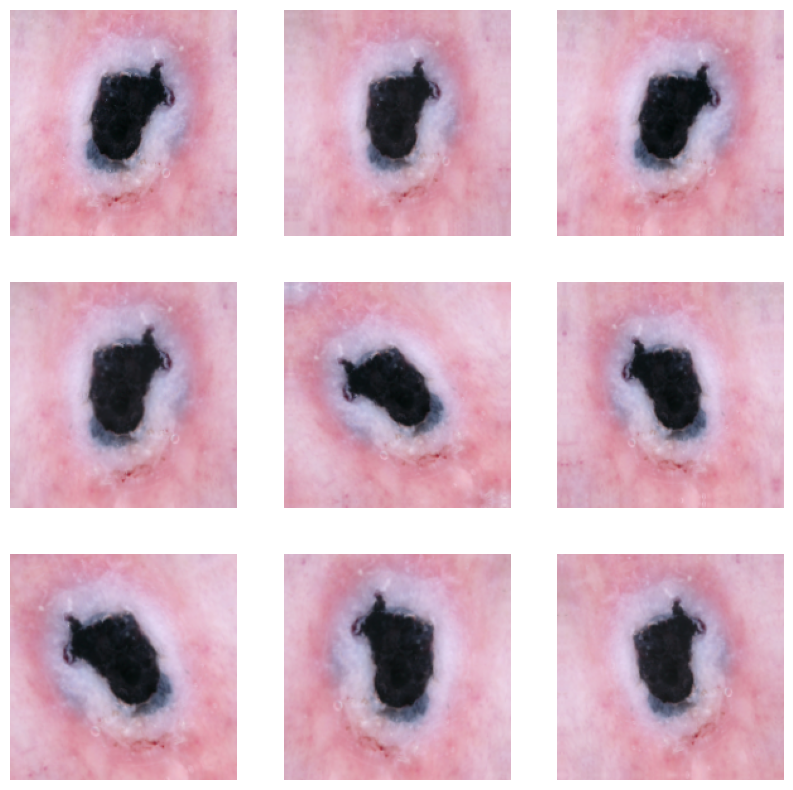

In [18]:
# Visualize a few augmented images to verify the transformations
for images, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        augmented_image = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()

In [ ]:
# Create the CNN model
modelB = models.Sequential([
        layers.Input(shape=(img_height, img_width, 3)),
        data_augmentation,                                                 # New layer - apply data augmentation before the Rescaling layer. Only applies to fit
        layers.Rescaling(1./255),                                          
        
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),

        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),

        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),

        # Flatten and add dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),

        layers.Dense(num_classes, activation='softmax')  # Output layer with softmax for multi-class classification
    ],
    name='ModelB'
)

#### Compile the model

In [20]:
# Compile the model
modelB.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
modelB.summary()

Model: "ModelB"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

#### Train the model

In [21]:
# Train the model
epochs = 20
historyB = modelB.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 427ms/step - accuracy: 0.1688 - loss: 3.0891 - val_accuracy: 0.1924 - val_loss: 2.0646
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 428ms/step - accuracy: 0.1878 - loss: 2.0483 - val_accuracy: 0.2908 - val_loss: 2.0298
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 417ms/step - accuracy: 0.2626 - loss: 1.9916 - val_accuracy: 0.3043 - val_loss: 1.9352
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 430ms/step - accuracy: 0.3574 - loss: 1.8018 - val_accuracy: 0.2438 - val_loss: 2.0236
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 450ms/step - accuracy: 0.3760 - loss: 1.7556 - val_accuracy: 0.3266 - val_loss: 1.8363
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 453ms/step - accuracy: 0.4115 - loss: 1.7152 - val_accuracy: 0.4027 - val_loss: 1.7672
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 450ms/step - accuracy: 0.4318 - loss: 1.6091 - val_accuracy: 0.4273 - val_loss: 1.6630
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 425ms/step - accuracy: 0.4347 - loss: 1.5943 - val_accu

#### Visualizing the results

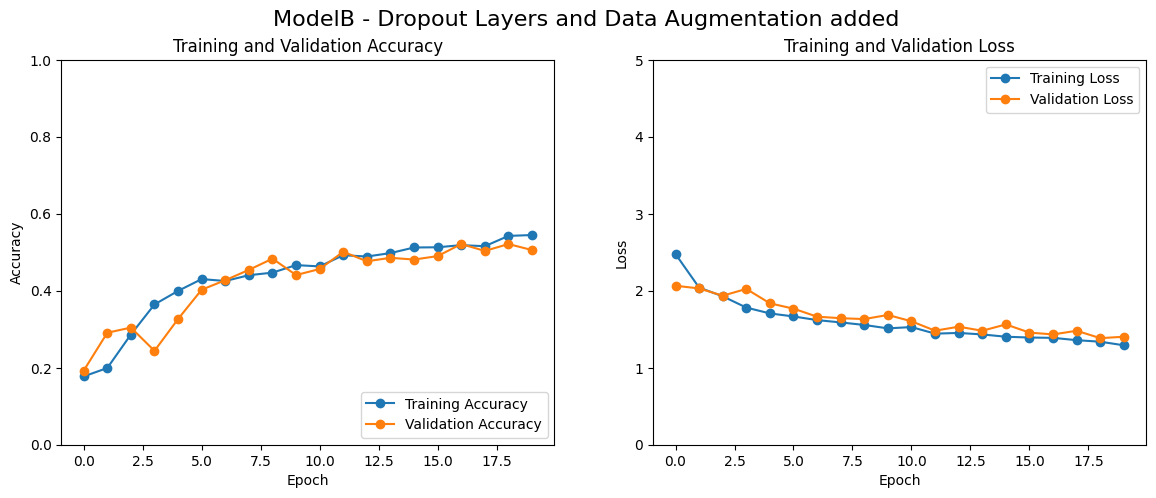

In [23]:
plot_training_history(history=historyB, model_name='ModelB - Dropout Layers and Data Augmentation added')

#### ModelB Performance Summary

ModelB shows improved generalization compared to ModelA by incorporating data augmentation and dropout. 

- **Training Loss**: Decreased consistently, reaching **1.2642** by epoch 20.  
- **Validation Loss**: Stabilized between **1.4323** and **1.4801**, indicating reduced overfitting.  
- **Validation Accuracy**: Peaked at **52.1%** during epoch 17 and remained more stable than in ModelA.  

The closer alignment between training and validation performance highlights how regularization techniques and augmented variability in the training data have helped reduce overfitting, though the overall accuracy improvement is modest.

### Class distribution

We recognize the presence of class imbalance in the image data and will visualize it here.

Found 2239 files belonging to 9 classes.


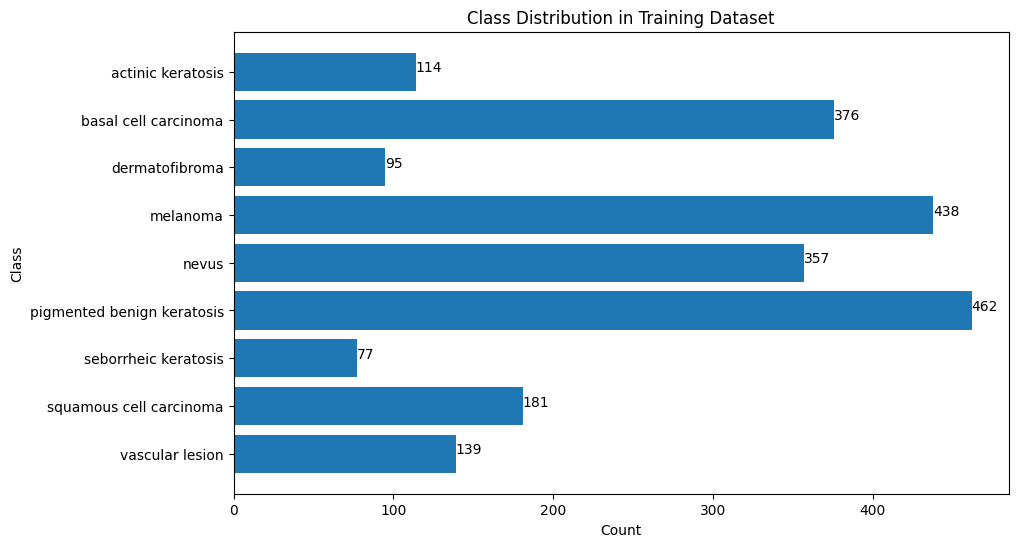

In [26]:
train_ds_temp = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Count the occurrences of each class in the training dataset
class_names = train_ds_temp.class_names
class_counts = {class_name: 0 for class_name in class_names}

for _, labels in train_ds_temp:
    for label in labels:
        class_counts[class_names[label]] += 1

# Convert to a DataFrame for easier plotting and display
class_distribution = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(class_distribution['Class'], class_distribution['Count'])
plt.xlabel("Count")
plt.ylabel("Class")
plt.title("Class Distribution in Training Dataset")
plt.gca().invert_yaxis()  # For better alignment of long class names

# Display count on each bar
for index, value in enumerate(class_distribution['Count']):
    plt.text(value, index, str(value))

plt.show()

### Rectify class imbalance using Augmentor

**Handling Class Imbalance with Augmentor**

We are addressing class imbalance in the dataset by generating additional images for underrepresented classes using the **Augmentor** library. This ensures that all classes have at least 500 samples, complementing the existing data augmentation pipeline without overlapping in transformation methods.

---

**How Augmentor Works**

Augmentor creates new image samples by applying a series of transformations to the existing images in each class folder. It allows us to specify augmentation operations such as skewing, brightness adjustment, cropping, and resizing, generating diverse and realistic images while maintaining the original label of the augmented data.


In [27]:
# We are using augmentor library to create 500 images per class.

target_count = 500

# Delete existing 'Output' folder
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
   
    # Check if the 'output' folder exists within the class directory
    output_path = os.path.join(class_path, "output")
    if os.path.exists(output_path) and os.path.isdir(output_path):
        # Delete the 'output' folder and all its contents
        shutil.rmtree(output_path)
        print(f"Deleted 'output' folder in {class_name} directory.")
    else:
        print(f"No 'output' folder found in {class_name} directory.")

# Apply augmentation only to classes with fewer samples than the target
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    
    # Count current samples in the class folder
    current_count = len(os.listdir(class_path))
    
    if current_count < target_count:
        # Set up the Augmentor pipeline for this class
        p = Augmentor.Pipeline(class_path)
        
        # Doing augmentations not done by `data_augmentation` 
        p.skew(probability=0.5, magnitude=0.1)                                    # Skew images slightly
        p.random_brightness(probability=0.5, min_factor=0.8, max_factor=1.2)      # Adjust brightness slightly
        p.crop_random(probability=0.5, percentage_area=0.9)                       # Random cropping to 90% area
        p.resize(probability=1.0, width=img_width, height=img_height)             # Resize back to target dimensions
        

        # Define the number of samples to generate
        samples_to_generate = target_count - current_count
        
        # Run the augmentation pipeline
        p.sample(samples_to_generate)

No 'output' folder found in actinic keratosis directory.
No 'output' folder found in basal cell carcinoma directory.
No 'output' folder found in dermatofibroma directory.
No 'output' folder found in melanoma directory.
No 'output' folder found in nevus directory.
No 'output' folder found in pigmented benign keratosis directory.
No 'output' folder found in seborrheic keratosis directory.
No 'output' folder found in squamous cell carcinoma directory.
No 'output' folder found in vascular lesion directory.
Initialised with 114 image(s) found.
Output directory set to data/Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x1CD81EBE060>: 100%|██████████| 386/386 [00:01<00:00, 317.90 Samples/s]


Initialised with 376 image(s) found.
Output directory set to data/Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x1CD7FE50830>: 100%|██████████| 124/124 [00:00<00:00, 300.35 Samples/s]


Initialised with 95 image(s) found.
Output directory set to data/Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x1CD7E2F7050>: 100%|██████████| 405/405 [00:01<00:00, 318.26 Samples/s]


Initialised with 438 image(s) found.
Output directory set to data/Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x1CD7E480710>: 100%|██████████| 62/62 [00:00<00:00, 83.39 Samples/s]


Initialised with 357 image(s) found.
Output directory set to data/Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x1CCF802D0D0>: 100%|██████████| 143/143 [00:01<00:00, 102.14 Samples/s]


Initialised with 462 image(s) found.
Output directory set to data/Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x1CCF789C080>: 100%|██████████| 38/38 [00:00<00:00, 282.16 Samples/s]


Initialised with 77 image(s) found.
Output directory set to data/Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x1CD7FE83B30>: 100%|██████████| 423/423 [00:02<00:00, 186.68 Samples/s]


Initialised with 181 image(s) found.
Output directory set to data/Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x1CCB22ACF50>: 100%|██████████| 319/319 [00:00<00:00, 323.69 Samples/s]


Initialised with 139 image(s) found.
Output directory set to data/Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x1CD7FE506E0>: 100%|██████████| 361/361 [00:01<00:00, 330.48 Samples/s]


#### Verify revised sample sizes

In [28]:
# Count images in training directory
print("Training Dataset Image Counts:")
for class_name in sorted(os.listdir(train_dir)):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        image_paths = glob.glob(os.path.join(class_path, '**', '*.[jp][pn]g'), recursive=True)
        print(f"  {class_name}: {len(image_paths)}")

# Count images in test directory
print("\nTest Dataset Image Counts:")
for class_name in sorted(os.listdir(test_dir)):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        image_paths = glob.glob(os.path.join(class_path, '**', '*.[jp][pn]g'), recursive=True)
        print(f"  {class_name}: {len(image_paths)}")

Training Dataset Image Counts:
  actinic keratosis: 500
  basal cell carcinoma: 500
  dermatofibroma: 500
  melanoma: 500
  nevus: 500
  pigmented benign keratosis: 500
  seborrheic keratosis: 500
  squamous cell carcinoma: 500
  vascular lesion: 500

Test Dataset Image Counts:
  actinic keratosis: 16
  basal cell carcinoma: 16
  dermatofibroma: 16
  melanoma: 16
  nevus: 16
  pigmented benign keratosis: 16
  seborrheic keratosis: 3
  squamous cell carcinoma: 16
  vascular lesion: 3


#### Build training and validation pipeline

In [29]:
# Parameters
batch_size = 128
img_height = 180
img_width = 180
AUTOTUNE = tf.data.AUTOTUNE

# Load training data with an 80-20 split
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Load validation data
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Load test data
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=118                          # All images as one single batch
)

# Use prefetching with AUTOTUNE to optimize performance
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)


Found 4500 files belonging to 9 classes.
Using 3600 files for training.
Found 4500 files belonging to 9 classes.
Using 900 files for validation.
Found 118 files belonging to 9 classes.


#### Compile the model

In [ ]:
# Create the CNN model
modelC = models.Sequential([
        layers.Input(shape=(img_height, img_width, 3)),
        data_augmentation,
        layers.Rescaling(1./255),
        
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.1),

        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.1),

        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.1),

        # Flatten and add dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),

        layers.Dense(num_classes, activation='softmax')  # Output layer with softmax for multi-class classification
    ],
    name='ModelC'
)

In [31]:
# Compile the model
modelC.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
modelC.summary()

Model: "ModelC"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

#### Train the model

In [32]:
# Train the model
epochs = 30
historyC = modelC.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 840ms/step - accuracy: 0.1158 - loss: 2.7547 - val_accuracy: 0.1144 - val_loss: 2.1967
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 847ms/step - accuracy: 0.1642 - loss: 2.1710 - val_accuracy: 0.2189 - val_loss: 1.9911
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 24s 841ms/step - accuracy: 0.2529 - loss: 1.8979 - val_accuracy: 0.3456 - val_loss: 1.7577
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 24s 829ms/step - accuracy: 0.3451 - loss: 1.6771 - val_accuracy: 0.3889 - val_loss: 1.5893
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 27s 931ms/step - accuracy: 0.3823 - loss: 1.5604 - val_accuracy: 0.3867 - val_loss: 1.5843
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 24s 835ms/step - accuracy: 0.3935 - loss: 1.5187 - val_accuracy: 0.4311 - val_loss: 1.4910
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 24s 837ms/step - accuracy: 0.4342 - loss: 1.4644 - val_accuracy: 0.4356 - val_loss: 1.4954
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 879ms/step - accuracy: 0.4419 - loss: 1.4286 - val_accu

#### Visualize the model results

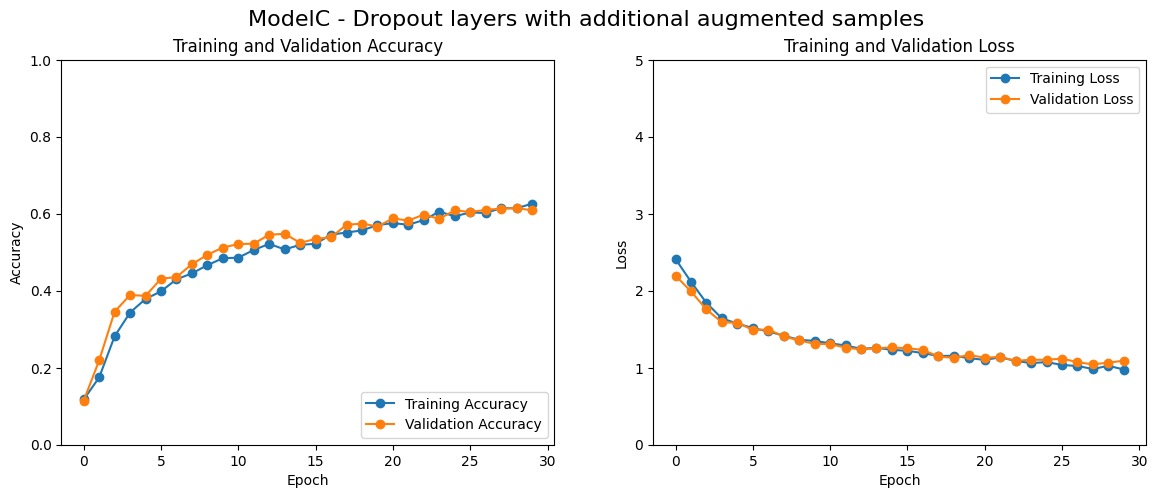

In [33]:
plot_training_history(history=historyC, model_name='ModelC - Dropout layers with additional augmented samples')

#### ModelC Performance Summary

ModelC uses the same architecture as ModelB but is trained on a combination of augmented and original images to address class imbalance and improve generalization.

- **Training Accuracy and Loss**:
  - Training accuracy steadily increases to **63.4%** by epoch 30.
  - Training loss decreases consistently, reaching **0.9842**, indicating effective learning on the enriched dataset.

- **Validation Accuracy and Loss**:
  - Validation accuracy improves significantly, peaking at **60.0%**, with a much closer alignment to training accuracy compared to ModelB.
  - Validation loss decreases steadily to **1.1032**, demonstrating better generalization and reduced overfitting.

- **Generalization**:
  - The training and validation curves are closely aligned, indicating that the additional augmented data helped balance the dataset and reduced overfitting.

ModelC highlights how incorporating augmented samples alongside the original data improves the model's robustness and generalization, outperforming ModelB on validation metrics.

### Testing ModelC on Unseen Data (test_ds)

This code evaluates the performance of `ModelC` on the test dataset (`test_dataset`). It computes the test accuracy and loss, generates predictions, and provides a detailed analysis of the model's performance using a classification report and confusion matrix.


Test Accuracy:  38.14%
Test Loss:      2.6392

Classification Report:
                            precision    recall  f1-score   support

         actinic keratosis       0.00      0.00      0.00        16
      basal cell carcinoma       0.17      0.12      0.14        16
            dermatofibroma       0.20      0.19      0.19        16
                  melanoma       0.00      0.00      0.00        16
                     nevus       0.16      0.31      0.21        16
pigmented benign keratosis       0.11      0.12      0.11        16
      seborrheic keratosis       0.33      0.33      0.33         3
   squamous cell carcinoma       0.29      0.25      0.27        16
           vascular lesion       0.00      0.00      0.00         3

                  accuracy                           0.14       118
                 macro avg       0.14      0.15      0.14       118
              weighted avg       0.13      0.14      0.13       118



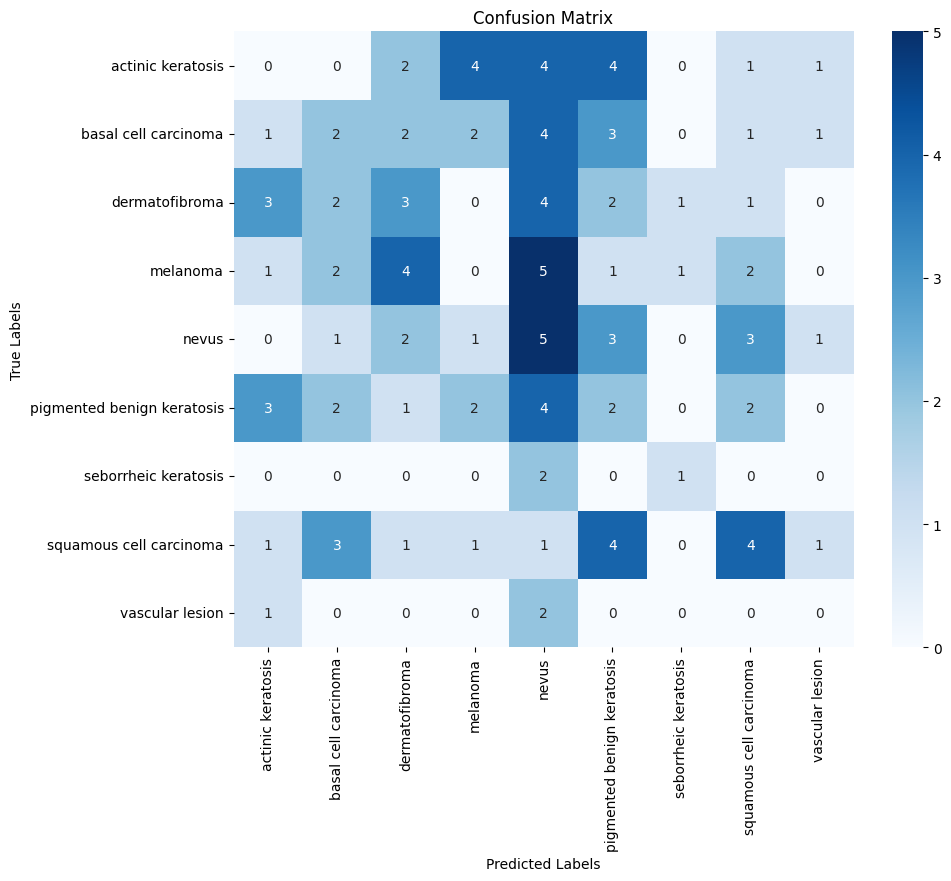

In [56]:
# Evaluate ModelC on the test dataset
test_loss, test_accuracy = modelC.evaluate(test_dataset, verbose=False)

# Print the test results
print(f"Test Accuracy:  {test_accuracy * 100:.2f}%")
print(f"Test Loss:      {test_loss:.4f}")

# Generate predictions
predictions = modelC.predict(test_dataset, verbose=False)
predicted_classes = tf.argmax(predictions, axis=1)

# Extract true labels
true_labels = tf.concat([y for x, y in test_ds], axis=0)

# Calculate and display a classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_classes, target_names=test_ds.class_names))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_ds.class_names, yticklabels=test_ds.class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


#### Explanation for Low Test Scores

The low accuracy and poor classification metrics on the test dataset can be attributed to the following reasons:

1. **Severe Class Imbalance**:
   - Despite augmenting samples, the training dataset still reflects an imbalance in the original class distributions (e.g., **actinic keratosis** with only 114 samples vs. **pigmented benign keratosis** with 462 samples).
   - The model may have learned biased representations, favoring majority classes and struggling with minority ones, as evidenced by the confusion matrix and low recall for underrepresented classes.

2. **Augmentation Limitations**:
   - Augmented images can add diversity, but they are `still derived from existing data`, limiting the variability introduced. This may not fully bridge the gap for classes with very few samples (e.g., **vascular lesion** with only 3 test samples).

3. **Complexity of Classes**:
   - Some skin lesion classes have inherently similar visual features, making them harder to distinguish even for well-trained models. For example, the confusion matrix shows significant overlap between **melanoma** and **nevus**, which are visually similar.

4. **Overfitting on Training Data**:
   - The training dataset might still dominate the model’s learning process. While augmentation improves generalization, the low test performance indicates that the model hasn't fully generalized to unseen data, especially for minority classes.

5. **Insufficient Representation in Test Data**:
   - The test dataset itself has only a few samples for certain classes (e.g., **vascular lesion** has 3 samples). This makes it challenging to measure the model’s true performance on underrepresented classes and likely skews the metrics.

#### Key Observations:
- Classes like **actinic keratosis** and **vascular lesion** suffer from **zero precision and recall**, highlighting the lack of sufficient data for these classes to train the model effectively.
- Majority classes like **pigmented benign keratosis** and **seborrheic keratosis** perform relatively better but still lack high precision or recall due to model underperformance.

To address this, further improvements are needed in balancing the dataset, refining the model architecture, and possibly incorporating external datasets for better representation of minority classes.